<a href="https://colab.research.google.com/github/airsresincrop/AIRS/blob/master/pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tensorboard
!gdown https://drive.google.com/uc?id=1rxR0XTiDbPeJg88WLZctzPwuL9JquC4g
!unzip -qq AIRS_512.zip
!rm AIRS_512.zip

Requirement already up-to-date: tensorboard in /usr/local/lib/python3.6/dist-packages (2.2.1)
Downloading...
From: https://drive.google.com/uc?id=1rxR0XTiDbPeJg88WLZctzPwuL9JquC4g
To: /content/AIRS_512.zip
32.8MB [00:00, 104MB/s] 


In [0]:
import tensorflow as tf

import os
import time
import numpy as np
from tqdm.notebook import tqdm
from pathlib import Path

from matplotlib import pyplot as plt
from IPython import display

In [3]:
for split in ['train','val','test']:
  images = files = [f[:-4] for f in os.listdir(f'full_data/AIRS_512/crop_full/{split}/images/') if 'jpg' in f]
  Path(f'AIRS_512/{split}').mkdir(parents = True, exist_ok = True)
  for f in tqdm(images, desc = split):
    img = plt.imread(f'full_data/AIRS_512/crop_full/{split}/images/{f}.jpg')
    lbl = plt.imread(f'full_data/AIRS_512/crop_full/{split}/labels/{f}.tif')*255
    stack = np.concatenate([img, lbl],axis=1)
    plt.imsave(f'AIRS_512/{split}/{f}.png',stack)

In [0]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 512
IMG_HEIGHT = 512
PATH = 'AIRS_512/'

In [0]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_png(image)[:,:,:3]

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, w:, :]
  input_image = image[:, :w, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

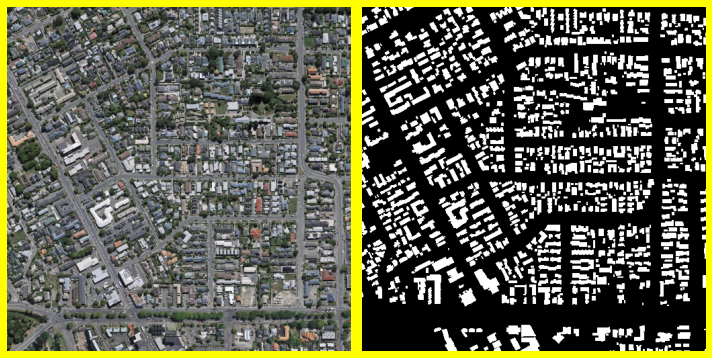

In [113]:
inp, re = load(PATH+'train/99.png')
# casting to int for matplotlib to show the image
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(inp/255.0)
plt.axis('off')
plt.tight_layout()
plt.subplot(122)
plt.imshow(re/255.0)
plt.axis('off')
plt.tight_layout()
fig.set_facecolor('yellow')

In [0]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [0]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [0]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [0]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 572 x 572 x 3
  input_image, real_image = resize(input_image, real_image, 572, 572)

  # randomly cropping to 512 x 512 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

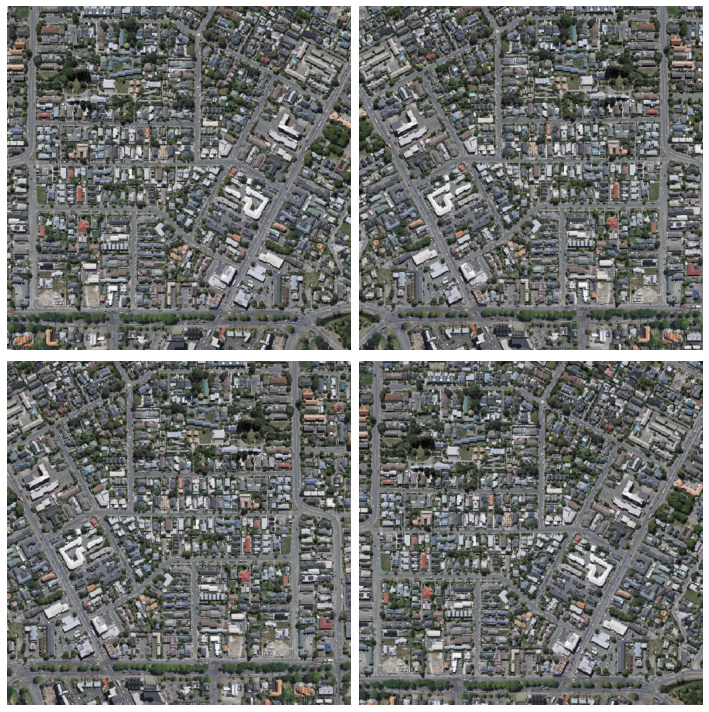

In [118]:
fig = plt.figure(figsize=(10, 10))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
fig.tight_layout()

In [0]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [0]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [0]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [0]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [0]:
OUTPUT_CHANNELS = 3

In [0]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [125]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 256, 256, 3)


In [0]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [127]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 512, 512, 3)


In [0]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_WIDTH,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 256, 256, 64)
    downsample(128, 4), # (bs, 128, 128, 128)
    downsample(256, 4), # (bs, 64, 64, 256)
    downsample(512, 4), # (bs, 32, 32, 512)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    #downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    #upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 16, 16, 1024)
    upsample(512, 4), # (bs, 32, 32, 1024)
    upsample(256, 4), # (bs, 64, 64, 512)
    upsample(128, 4), # (bs, 128, 128, 256)
    upsample(64, 4), # (bs, 256, 256, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 512, 512, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
def Generator(factor=1):
  inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_WIDTH,3])

  down_stack = [
    downsample(64//factor, 4, apply_batchnorm=False), # (bs, 256, 256, 64)
    downsample(128//factor, 4), # (bs, 128, 128, 128)
    downsample(256//factor, 4), # (bs, 64, 64, 256)
    downsample(512//factor, 4), # (bs, 32, 32, 512)
    downsample(512//factor, 4), # (bs, 16, 16, 512)
    downsample(512//factor, 4), # (bs, 8, 8, 512)
    downsample(512//factor, 4), # (bs, 4, 4, 512)
    downsample(512//factor, 4), # (bs, 2, 2, 512)
    #downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    #upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512//factor, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512//factor, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512//factor, 4, apply_dropout=True), # (bs, 16, 16, 1024)
    upsample(512//factor, 4), # (bs, 32, 32, 1024)
    upsample(256//factor, 4), # (bs, 64, 64, 512)
    upsample(128//factor, 4), # (bs, 128, 128, 256)
    upsample(64//factor, 4), # (bs, 256, 256, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 512, 512, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
generator = Generator(factor=2)
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


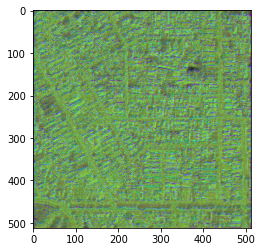

In [134]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

In [0]:
LAMBDA = 100

In [0]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [0]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 512, 512, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 256, 256, 64)
  down2 = downsample(128, 4)(down1) # (bs, 128, 128, 128)
  down3 = downsample(256, 4)(down2) # (bs, 64, 64, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 66, 66, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 63, 63, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 65, 65, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 62, 62, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [0]:
def Discriminator(factor=1):
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 512, 512, channels*2)

  down1 = downsample(64//factor, 4, False)(x) # (bs, 256, 256, 64)
  down2 = downsample(128//factor, 4)(down1) # (bs, 128, 128, 128)
  down3 = downsample(256//factor, 4)(down2) # (bs, 64, 64, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 66, 66, 256)
  conv = tf.keras.layers.Conv2D(512//factor, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 63, 63, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 65, 65, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 62, 62, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [0]:
discriminator = Discriminator(2)
#tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

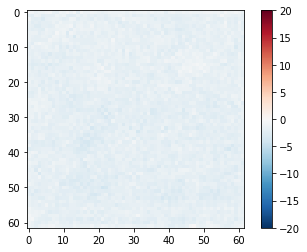

In [142]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=False)

  pred = np.array(prediction[0]*0.5+0.5)
  t = np.array(tar[0]*0.5+0.5)
  pred[pred>0.5] = 1
  pred[pred<=0.5] = 0
  fore_inter = np.logical_and(pred,t).sum()
  fore_union = np.logical_or(pred,t).sum()
  back_inter = np.logical_and(1-pred,1-t).sum()
  back_union = np.logical_or(1-pred,1-t).sum()
  miou = (fore_inter/fore_union + back_inter/back_union)/2
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
  print(f'mIoU: {miou}')

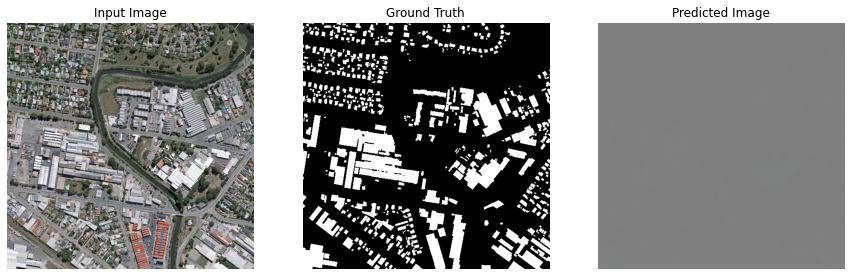

mIoU: 0.317172116581685


In [148]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [0]:
EPOCHS = 100

In [0]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [0]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [0]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

In [153]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 256), started 1:24:04 ago. (Use '!kill 256' to kill it.)

<IPython.core.display.Javascript object>

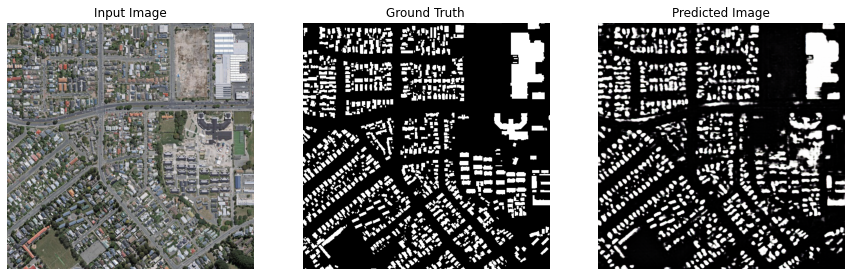

mIoU: 0.7258888702511441
Epoch:  10
.

In [0]:
fit(train_dataset, EPOCHS, test_dataset)

## Restore the latest checkpoint and test

In [42]:
!ls {checkpoint_dir}

checkpoint		    ckpt-4.data-00000-of-00002
ckpt-1.data-00000-of-00002  ckpt-4.data-00001-of-00002
ckpt-1.data-00001-of-00002  ckpt-4.index
ckpt-1.index		    ckpt-5.data-00000-of-00002
ckpt-2.data-00000-of-00002  ckpt-5.data-00001-of-00002
ckpt-2.data-00001-of-00002  ckpt-5.index
ckpt-2.index		    ckpt-6.data-00000-of-00002
ckpt-3.data-00000-of-00002  ckpt-6.data-00001-of-00002
ckpt-3.data-00001-of-00002  ckpt-6.index
ckpt-3.index


In [43]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate using test dataset

In [0]:
def test_miou(model, test_dataset):
  preds = np.zeros((20,512,512,3),dtype = np.uint8)
  ts = np.zeros((20,512,512,3),dtype = np.uint8)
  count = 0
  for inp, tar in test_dataset.take(20):
    prediction = model(inp, training=False)
    pred = np.array(prediction[0]*0.5+0.5)
    t = np.array(tar[0]*0.5+0.5)
    pred[pred>0.5] = 1
    pred[pred<=0.5] = 0
    preds[count] = pred
    ts[count] = t
    count += 1
  fore_inter = np.logical_and(preds,ts).sum()
  fore_union = np.logical_or(preds,ts).sum()
  back_inter = np.logical_and(1-preds,1-ts).sum()
  back_union = np.logical_or(1-preds,1-ts).sum()
  miou = (fore_inter/fore_union + back_inter/back_union)/2
  print(f'mIoU: {miou}')
  return preds, ts, miou

In [107]:
preds, ts, miou = test_miou(generator, test_dataset)

mIoU: 0.793721168758021


In [78]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

309399.25 ,
316362.1 ,
307999.34 ,
334465.56 ,
328608.72 ,
362585.9 ,
368896.8 ,
349048.4 ,
336747.53 ,
343148.0 ,
287824.28 ,
358881.12 ,
353976.6 ,
345210.38 ,
321064.97 ,
323967.34 ,
311856.97 ,
414561.5 ,
343612.7 ,
315969.56 ,
